# CS4120 Final Project

**Robert Yin**

Please read alongside the accompanying final report for full context, as each section here corresponds to a section with the same name in the report.

To run this notebook, first install the following libraries (plus your Python notebook environment of choice) using your Python package manager of choice. Then, run the entire notebook at once (restart the kernel if the notebook needs to be run again, as running certain cells out of order can cause some issues).

In [1]:
# built-in libraries
from collections import defaultdict
import re

# miscellaneous third-party libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import emoji
import dataframe_image as df_img
from nltk.tokenize import TweetTokenizer

# scikit-learn
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# ignore a few warnings from pandas, scikit-learn and dataframe_img
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

## Dataset Analysis

First, read in the dataset using `Pandas` and preserve the relevant columns.

In [2]:
DATA_PATH = "tweets.csv" 

initial_data = pd.read_csv(DATA_PATH)[["handle", "text", "is_retweet", "original_author"]]
initial_sample = initial_data.head(10)
df_img.export(initial_sample, "Initial Dataset.png")
initial_sample

[1209/190256.059985:INFO:headless_shell.cc(623)] Written to file /var/folders/bs/ly1984ds6lv54hw8_jfp__s40000gn/T/tmpvongyhik/temp.png.


,handle,text,is_retweet,original_author
0,HillaryClinton,The question in this election: Who can put the...,False,NaN
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS
3,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN
4,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False,NaN
6,HillaryClinton,This election is too important to sit out. Go ...,False,NaN
7,HillaryClinton,When Donald Trump goes low...register to vote:...,False,NaN
8,realDonaldTrump,"Once again, we will have a government of, by a...",False,NaN
9,HillaryClinton,3) Has Trump offered a single proposal to redu...,True,mcuban


Display tweet handle parity before any filtering is done.

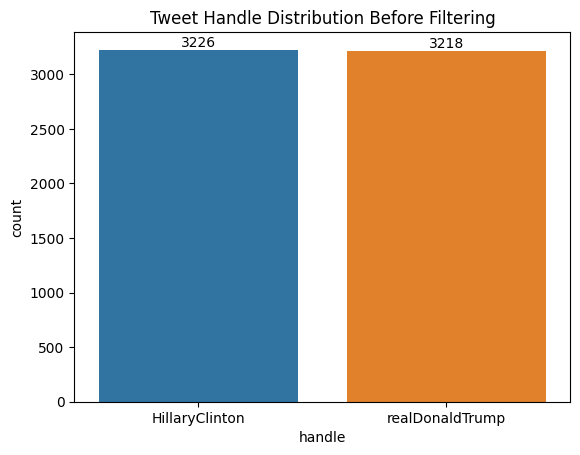

In [3]:
def plot_tweet_counts(df: pd.DataFrame, title: str, save_fig: bool = True) -> None:
    """Plot the number of tweets from each user handle.
    
    The minimum column required is "handle".
    
    Args:
        df: The DataFrame containing the tweets.
        file: Optional file path for saving the plot figure.
    """
    plot_data = {"handle": [], "count": []}
    for handle in df["handle"].unique():
        num_tweets = len(df[df["handle"] == handle])
        plot_data["handle"].append(handle)
        plot_data["count"].append(num_tweets)
    plot_data = pd.DataFrame(plot_data)
    plot = sb.barplot(plot_data, x="handle", y="count")
    plot.bar_label(plot.containers[0])
    plot.set(title=title)
    if save_fig:
        mp.pyplot.savefig(f"{title}.png")
        
plot_tweet_counts(initial_data, "Tweet Handle Distribution Before Filtering")

Show any retweets that might contain duplicate tweet texts from original tweets.

In [4]:
possible_duplicates = initial_data[initial_data["original_author"].isin(initial_data["handle"].unique())]["text"]
sample_dupes = initial_data[initial_data["text"].isin(possible_duplicates)]
df_img.export(sample_dupes, "Duplicate Tweet Entries.png")
sample_dupes

[1209/190256.947954:INFO:headless_shell.cc(623)] Written to file /var/folders/bs/ly1984ds6lv54hw8_jfp__s40000gn/T/tmp00vjs0t1/temp.png.


,handle,text,is_retweet,original_author
772,HillaryClinton,A man who talks about our veterans and militar...,True,HillaryClinton
793,HillaryClinton,A man who talks about our veterans and militar...,False,NaN
3467,realDonaldTrump,HAPPY 241st BIRTHDAY to the @USArmy! THANK YOU...,True,realDonaldTrump
3468,realDonaldTrump,HAPPY 241st BIRTHDAY to the @USArmy! THANK YOU...,False,NaN


Filter out all retweets.

In [5]:
original_tweet_data = initial_data.loc[initial_data["is_retweet"] == False]
original_tweet_data["is_retweet"].unique()

array([False])

Only the `handle` and `text` columns are necessary for training and scoring the models.

,handle,text
0,HillaryClinton,The question in this election: Who can put the...
3,HillaryClinton,"If we stand together, there's nothing we can't..."
4,HillaryClinton,Both candidates were asked about how they'd co...
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...
6,HillaryClinton,This election is too important to sit out. Go ...
...,...,...
6439,realDonaldTrump,"""@lilredfrmkokomo: @realDonaldTrump My Faceboo..."
6440,realDonaldTrump,"""@marybnall01: @realDonaldTrump watched lowell..."
6441,realDonaldTrump,"""@ghosthunter_lol: Iowa key endorsement for @r..."
6442,realDonaldTrump,"""@iLoveiDevices: @EdwinRo47796972 @happyjack22..."


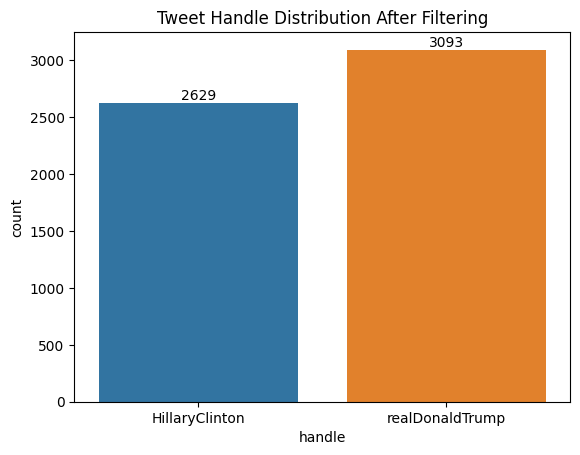

In [6]:
tweet_data = original_tweet_data[["handle", "text"]]
plot_tweet_counts(tweet_data, "Tweet Handle Distribution After Filtering")
tweet_data

## Data Normalization and Representation

Map each `handle` to an integer value for a `label`.

In [7]:
LABELS = {
    "HillaryClinton": 0,
    "realDonaldTrump": 1,
}

def label_data(data: pd.DataFrame, labels: dict[str, int] = LABELS) -> pd.DataFrame:
    """Add a label column to a DataFrame.
    
    Each label is a pre-defined mapping of each tweet's handle.
    
    Args:
        data: The DataFrame to label.
        labels: The mapping of "handle" to "label" value.
        
    Returns:
        The DataFrame with labels attached and handles dropped.
    """
    labeled = data
    labeled["label"] = data["handle"].map(LABELS)
    return labeled.drop(columns=["handle"])

labeled_data = label_data(tweet_data)
sample_labeled = labeled_data.head()
df_img.export(sample_labeled, "Labeled Tweets.png")
sample_labeled

[1209/190257.817497:INFO:headless_shell.cc(623)] Written to file /var/folders/bs/ly1984ds6lv54hw8_jfp__s40000gn/T/tmp8mf2r68j/temp.png.


,text,label
0,The question in this election: Who can put the...,0
3,"If we stand together, there's nothing we can't...",0
4,Both candidates were asked about how they'd co...,0
5,Join me for a 3pm rally - tomorrow at the Mid-...,1
6,This election is too important to sit out. Go ...,0


Normalize tokens in each tweet.

In [8]:
HYPERLINK_REGEX = r"http(s*)://[^ ]+"
HYPERLINK_TOKEN = "<LINK>"
HASHTAG_REGEX = r"#[^ ]+"
MENTION_REGEX = r"@[^ ]+"
TOKENIZER = TweetTokenizer()

def valid_token(token: str) -> bool:
    """Determine if a token is a valid token.
    
    Args:
        The token to validate.
        
    Returns:
        Whether the token is valid.
    """
    return (
        token.isalnum() or 
        emoji.is_emoji(token) or 
        re.search(fr"({HYPERLINK_REGEX})|({HASHTAG_REGEX})|({MENTION_REGEX})", token)
    )

assert valid_token("VaLiD123")
assert valid_token("👁")
assert valid_token("https://google.com/asdf-234_fej")
assert valid_token("#HelloThere")
assert not valid_token("notvalid!")

def clean_token(token: str) -> str:
    """Clean a single token; token is assumed to be valid.
    
    Args:
        token: The uncleaned, but valid token.
        
    Returns:
        The cleaned token.
    """
    if emoji.is_emoji(token):
        return emoji.demojize(token)
    elif re.search(HYPERLINK_REGEX, token):
        return re.sub(HYPERLINK_REGEX, HYPERLINK_TOKEN, token)
    elif token.isalnum():
        return token.lower()
    else:
        return token
    
assert clean_token("VaLiD123") == "valid123"
assert clean_token("👁") == ":eye:"
assert clean_token("https://google.com/asdf-234_fej") == "<LINK>"
assert clean_token("#HelloThere") == "#HelloThere"

def clean(text: str, tokenizer: TweetTokenizer = TOKENIZER) -> str:
    """Clean text into valid and formatted tokens.
    
    Args:
        text: The uncleaned text.
        tokenizer: The tokenizer used to split words into tokens.
        
    Returns:
        The cleaned and formatted tokens as a single string.
    """
    tokens = tokenizer.tokenize(text)
    return " ".join([clean_token(token) for token in tokens if valid_token(token)])

assert clean("VaLiD123! 👁, https://google.com/asdf-234_fej #Hello") == "valid 123 :eye: <LINK> #Hello"

def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """Clean the text column of a DataFrame.
    
    Args:
        data: The DataFrame to clean.
        
    Returns:
        The DataFrame with each tweet's text cleaned.
    """
    cleaned = data
    cleaned["text"] = data["text"].map(clean)
    return cleaned

In [9]:
EXAMPLE_INDICES = [75, 89, 495]

for example in EXAMPLE_INDICES:
    original = labeled_data.iloc[example]["text"]
    print(f"Original: \"{original}\"")

Original: "Hillary Clinton failed all over the world. 
❌LIBYA
❌SYRIA
❌IRAN
❌IRAQ
❌ASIA PIVOT
❌RUSSIAN RESET
❌BENGHAZI… https://t.co/OoakXs2rij"
Original: "We’ve got to address the systemic racism in our criminal justice system and end private prisons. #DebateNight https://t.co/8afCXJAAjI"
Original: "#ImWithYou #AmericaFirst https://t.co/Ne4pI7FyU7"


In [10]:
EXAMPLE_INDICES = [75, 89, 495]

cleaned_data = clean_data(labeled_data)

for example in EXAMPLE_INDICES:
    cleaned = cleaned_data.iloc[example]["text"]
    print(f"Cleaned: \"{cleaned}\"")

Cleaned: "hillary clinton failed all over the world :cross_mark: libya :cross_mark: syria :cross_mark: iran :cross_mark: iraq :cross_mark: asia pivot :cross_mark: russian reset :cross_mark: benghazi <LINK>"
Cleaned: "we ve got to address the systemic racism in our criminal justice system and end private prisons #DebateNight <LINK>"
Cleaned: "#ImWithYou #AmericaFirst <LINK>"


In [11]:
cleaned_data

,text,label
0,the question in this election who can put the ...,0
3,if we stand together nothing we do make sure r...,0
4,both candidates were asked about how confront ...,0
5,join me for a 3pm rally tomorrow at the center...,1
6,this election is too important to sit out go t...,0
...,...,...
6439,@lilredfrmkokomo @realDonaldTrump my facebook ...,1
6440,@marybnall01 @realDonaldTrump watched lowell m...,1
6441,@ghosthunter_lol iowa key endorsement for @rea...,1
6442,@iLoveiDevices @EdwinRo47796972 @happyjack225 ...,1


The gold labels are just all of the labels associated with each input tweet.

In [12]:
gold_labels = cleaned_data["label"]
gold_labels.shape

(5722,)

All of the models will be using a bag-of-words representation for the input texts. A bag-of-words representation of our input texts can be created using `scikit-learn`'s `CountVectorizer`. A custom regular expression is used to preserve the tokens created from the last step, while the `preprocessor` that the vectorizer uses is an identity lambda, as pre-processing has already been done.

In [13]:
TOKEN_REGEX = r"[a-zA-Z]+|\:[a-zA_Z]+\:|\<LINK\>"

vectorizer = CountVectorizer(token_pattern=TOKEN_REGEX, preprocessor = lambda x: x)
bag_of_words = vectorizer.fit_transform(cleaned_data["text"]).todense()

print(bag_of_words.shape)
print(vectorizer.get_feature_names_out(bag_of_words))

(5722, 8280)
[':angry_face_with_horns:' ':backhand_index_pointing_left:'
 ':backhand_index_pointing_right:' ... 'zucker' 'zuckerman' 'zulu']


## Hyperparameters and Cross-Fold Validation

Generate hyperparameter names and values for each model.

In [14]:
def range_zero_one() -> list[float]:
    """Generate a list of floats from 0 to 1, stepping by 0.1.
    
    0 is inclusive, but represented by 1.0e-10 to avoid issues with models.
    1 is also inclusive, but genuinely as the value of 1.0
    
    Returns:
        The list of floats.
    """
    return [max(x / 10, 1.0e-10) for x in range(11)]

MNB_PARAMS = {"alpha": range_zero_one()}
CNB_PARAMS = {"alpha": range_zero_one(), "norm": [True, False]}
LR_PARAMS = {"C": range_zero_one(), "fit_intercept": [True, False]}

print(MNB_PARAMS)
print(CNB_PARAMS)
print(LR_PARAMS)

{'alpha': [1e-10, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
{'alpha': [1e-10, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'norm': [True, False]}
{'C': [1e-10, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'fit_intercept': [True, False]}


Train and evaluate models using `GridSearchCV`.

In [15]:
def evaluate_with_parameters(
    model: BaseEstimator, 
    params: dict[str, any], 
    X: np.matrix, 
    y:pd.Series,
    verbose: int = 1,
) -> GridSearchCV:
    """Fit and return a GridCV object that fits and scores a model across possible hyperparameters.
    
    Args:
        model: The model to be evaluated.
        params: The possible hyperparameters for the model.
        X: The input, in this case the bag-of-words of our dataset.
        y: The gold labels for the input.
        verbose: Level of verbosity during fitting.
        
    Returns:
        The fitted and evaluated GridSearchCV object.
    """
    grid = GridSearchCV(model, params, scoring="f1", verbose=verbose)
    grid.fit(X=X, y=y)
    return grid

In [16]:
mnb_evaluation = evaluate_with_parameters(MultinomialNB(), MNB_PARAMS, bag_of_words, gold_labels)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


In [17]:
cnb_evaluation = evaluate_with_parameters(ComplementNB(), CNB_PARAMS, bag_of_words, gold_labels)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


In [18]:
lr_evaluation = evaluate_with_parameters(
    LogisticRegression(solver="liblinear"), 
    LR_PARAMS, 
    bag_of_words, 
    gold_labels,
)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


## Results

Extract and plot relevant metrics collected from `GridSearchCV`.

In [19]:
RELEVANT_METRICS = ["mean_test_score", "mean_fit_time", "mean_score_time"]

def plot_metrics(
        grid: GridSearchCV, 
        y_param: str, 
        x_param: str | None = None,
        file: str | None = None,
    ) -> None:
    """Plot relevant metrics of a fitted GridSearchCV's results.
    
    Args:
        grid: The fitted GridSearchCV.
        y_param: The parameter name to be plotted on the y-axis.
        x_param: The parameter name to be plotted on the x-axis, None if only 1 parameter.
        file: Optional file path to save figure.
    """
    data = metric_data(grid).set_index(y_param)
    fig, ax = mp.pyplot.subplots(1, len(RELEVANT_METRICS))
    fig.tight_layout(pad=3.5)
    for metric, axis in zip(RELEVANT_METRICS, ax):
        plot_metric(data, metric, x_param, y_param, axis)
    if file:
        mp.pyplot.savefig(file)
        
def plot_metric(data: pd.DataFrame, metric: str, x_param: str | None, y_param: str, axis: int) -> None:
    """Plot a single metric on a heatmap.
    
    Args:
        data: The full dataframe of all results from a GridSearchCV.
        metric: The name of the metric.
        x_param: The parameter name to be plotted on the x-axis, None if only 1 parameter.
        y_param: The parameter name to be plotted on the y-axis.
        axis: Axis to be plotted on.
    """
    if x_param:
        data = data[[metric, x_param]].pivot_table(metric, [y_param], x_param)
    else:
        data = data[[metric]]
    sb.heatmap(data, annot=True, ax=axis).set(title=format_title(metric))

def format_title(title: str) -> str:
    """Format the title of a metric for a plot.
    
    Replaces underscores with spaces and converts to title-case.
    
    Args:
        title: The metric title.
        
    Returns:
        The formatted title.
    """
    return title.replace("_", " ").title()

def metric_data(grid: GridSearchCV) -> pd.DataFrame:
    """Build the metric DataFrame from a GridSearchCV.
    
    Args:
        grid: The trained and scored GridSearchCV.
        
    Returns:
        A formatted DataFrame of revelevant metric data.
    """
    results = grid.cv_results_
    relevant_columns = [
        "mean_fit_time",
        "mean_test_score", 
        "mean_score_time",
    ]
    data = {relevant: results[relevant] for relevant in relevant_columns}
    data.update(map_params(results["params"]))
    return pd.DataFrame(data)

def map_params(params: list[dict[str, any]]) -> dict[str, list[any]]:
    """Map parameter objects to be a dictionary of flat lists.
    
    Necessary for DataFrames to properly represent parameter information.
    Example: [{"a": True, "b": 1}, {"a": False, "b": 45}] -> {"a": [True, False], b: [1 , 45]}
    
    Args:
        params: The list of parameter dictionaries.
        
    Returns:
        A dictionary of flattened parameter lists.
    """
    mapped = defaultdict(list)
    for param in params:
        for field in param:
            datum = param[field]
            datum = int(datum) if isinstance(datum, bool) else datum
            mapped[field].append(datum)
    return dict(mapped)

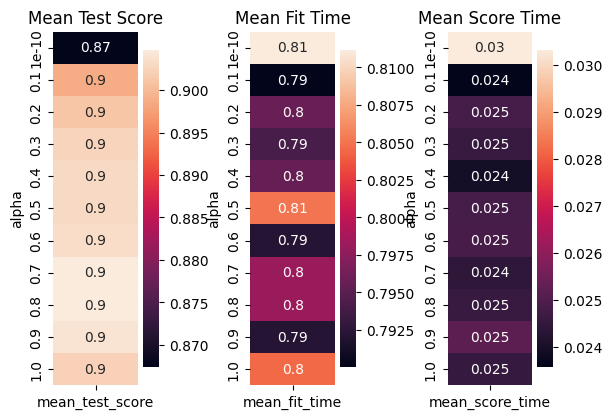

In [20]:
plot_metrics(mnb_evaluation, "alpha", file="MultinomialNB Metrics.png")

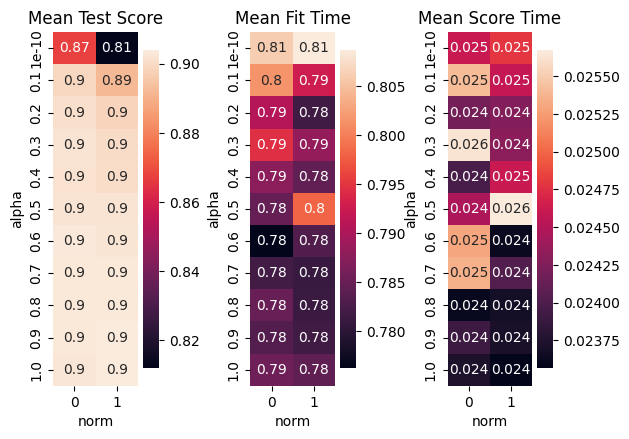

In [21]:
plot_metrics(cnb_evaluation, "alpha", "norm", file="ComplementNB Metrics.png")

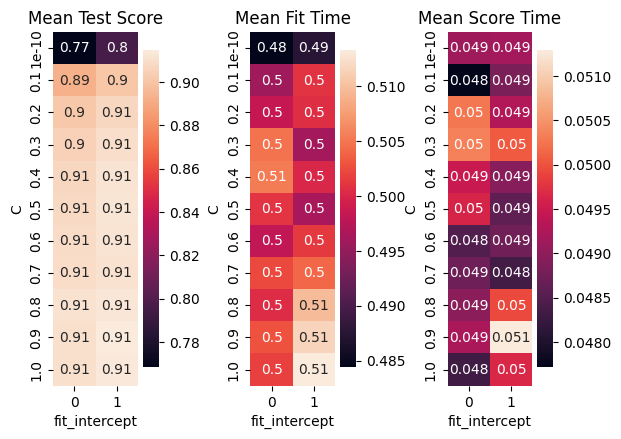

In [22]:
plot_metrics(lr_evaluation, "C", "fit_intercept", file="LogisticRegression Metrics.png")